In [1]:
import os

import numpy as np

data_dir = "Data/Car-Bike-Dataset"
class_names = os.listdir(data_dir)

print("class names: ", class_names)

class names:  ['Bike', 'Car']


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
images_path = []
labels = []

for cls_name in class_names:
    cls_path = os.path.join(data_dir, cls_name)

    for img_name in os.listdir(cls_path):
        if not(
            img_name.endswith('.jpg') or
            img_name.endswith('.jpeg') or
            img_name.endswith('.png')
        ):
          continue

        images_path.append(os.path.join(cls_name, img_name))
        labels.append(cls_name)

print("images: ", len(images_path))

images:  3996


In [4]:
from sklearn.model_selection import train_test_split

train_path, val_path, train_label, val_label = train_test_split(images_path, labels, test_size=0.2, random_state=42)

print("length of train: ", len(train_path))
print("length of val: ", len(val_path))

length of train:  3196
length of val:  800


In [5]:
import tensorflow as tf
from PIL import Image

def create_tf_dataset(images_path, labels):
    def generator():
        for idx, img_path in enumerate(images_path):
            img_path = os.path.join(data_dir, img_path)
            img = Image.open(img_path)

            if img.mode != "RGB":
                img = img.convert("RGB")

            label = class_names.index(labels[idx])
            label = np.array([label])

            yield img, label

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec((None, None, 3), dtype="float32"),
            tf.TensorSpec((1,), dtype="uint8")
        )
    )

train_dateset = create_tf_dataset(train_path, train_label)
val_dataset = create_tf_dataset(val_path, val_label)

In [6]:
def preprocess(image, label):
    image = tf.image.resize(image, size=(150, 150))

    image = tf.cast(image, dtype=tf.float32) / 255.0

    return image, label

train_dateset = train_dateset.map(preprocess)
val_dataset = val_dataset.map(preprocess)

In [7]:
import keras

input_shape = (150, 150, 3)

base_model = keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape)
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(1, activation="sigmoid")(x)

model = keras.models.Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 4,008,829 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [8]:
train_dateset = train_dateset.repeat().batch(8).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.repeat().batch(8).prefetch(tf.data.AUTOTUNE)

steps_per_epoch = 3196 // 8
validation_steps = 800 // 8

In [9]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=4,
    min_lr=1e-5
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

In [10]:
history = model.fit(
    train_dateset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 290s 638ms/step - accuracy: 0.9018 - loss: 0.2285 - val_accuracy: 0.9038 - val_loss: 0.5106 - learning_rate: 0.0010
Epoch 2/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 235s 590ms/step - accuracy: 0.9619 - loss: 0.1180 - val_accuracy: 0.4350 - val_loss: 0.9816 - learning_rate: 0.0010
Epoch 3/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 211s 529ms/step - accuracy: 0.9810 - loss: 0.0569 - val_accuracy: 0.4775 - val_loss: 24.3016 - learning_rate: 0.0010
Epoch 4/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 258s 647ms/step - accuracy: 0.9825 - loss: 0.0674 - val_accuracy: 0.5188 - val_loss: 36.6989 - learning_rate: 0.0010
Epoch 5/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 312s 782ms/step - accuracy: 0.9865 - loss: 0.0424 - val_accuracy: 0.5100 - val_loss: 0.7088 - learning_rate: 0.0010
Epoch 6/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 286s 718ms/step - accuracy: 0.9942 - loss: 0.0118 - val_accuracy: 0.9900 - val_loss: 0.0299 - learning_rate: 1.0000e-04
Epoch 7/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 245s 615ms/step - 

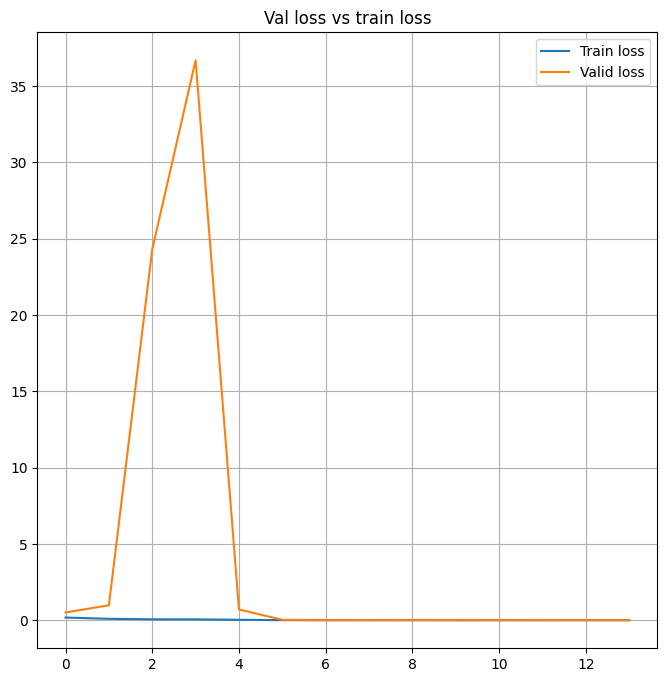

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.plot(history.history['loss'], label="Train loss")
plt.plot(history.history['val_loss'], label="Valid loss")
plt.title("Val loss vs train loss")

plt.grid(True)
plt.legend()
plt.show()

In [12]:
model.evaluate(val_dataset, steps=validation_steps)

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.9961 - loss: 0.0114


[0.01893124356865883, 0.9937499761581421]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


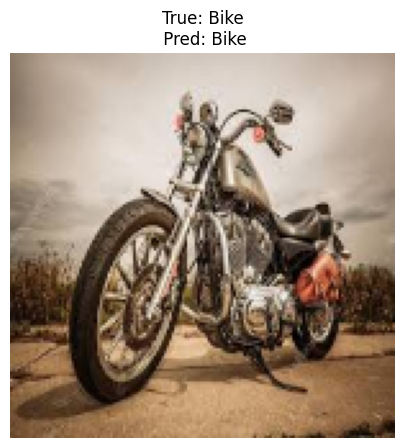

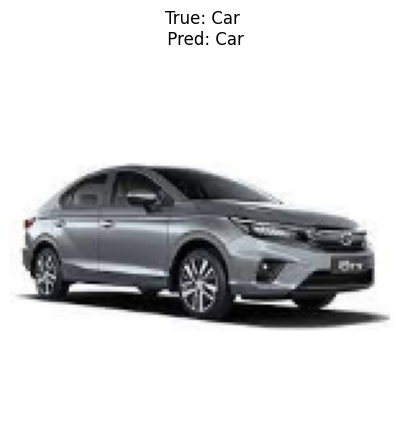

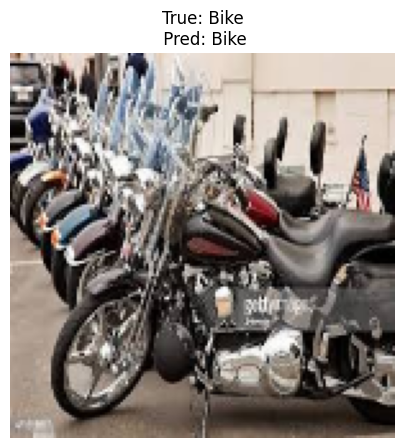

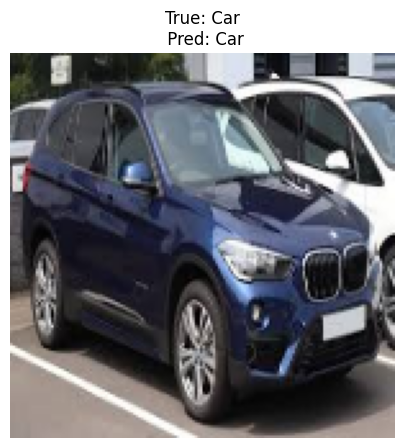

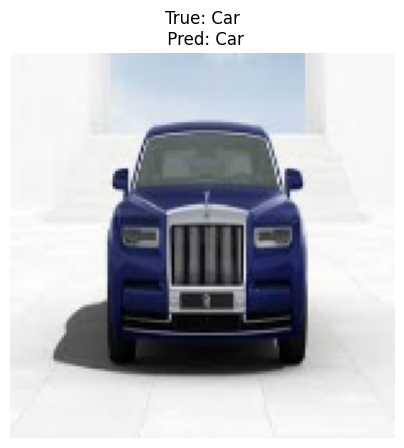

In [20]:
def visualize_predictions(model, dataset, class_names, num_samples):
    batch = next(iter(val_dataset))
    images, labels = batch

    num_samples = min(images.shape[0], num_samples)

    predictions = model.predict(images)

    for i in range(num_samples):
        img = images[i].numpy()
        predicted = predictions[i]
        label = labels[i].numpy()

        predicted = (predicted > 0.5).astype(int)
        img = img * 255.0
        img = img.astype('uint8')

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"True: {class_names[label[0]]}\n Pred: {class_names[predicted[0]]}")
        plt.axis('off')
        plt.show()

visualize_predictions(model, val_dataset, class_names, num_samples=5)

In [26]:
from sklearn.metrics import classification_report

y_true =  []
for label_name in val_label:
    y_true.append(class_names.index(label_name))

y_pred = model.predict(val_dataset, steps=validation_steps)

y_pred = (y_pred > 0.5).astype(int).flatten()

print(classification_report(y_true, y_pred))

100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       415
           1       0.99      1.00      0.99       385

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800

